<a href="https://colab.research.google.com/github/Satyake/Deep-Learning/blob/master/Copy_of_XPLORSPACE_17_Class_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#Flowers pre-sorted based on the information from the source : https://www.robots.ox.ac.uk/~vgg/data/flowers/17/
# 80 examples in each folder denoting each of the 17 classes.


In [ ]:
!unzip '/content/17flowers.zip'  #unzip function

**Helper Modules **

In [ ]:
import numpy
import keras
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense
from keras.layers import Conv2D
from keras.models import Sequential
from keras.layers import Flatten
import matplotlib.pyplot as plt
from keras.models import Model


In [ ]:
#dividing into train_test splits
!pip install split_folders

In [ ]:
import splitfolders
source='/content/jpg'
output='/content/'
splitfolders.ratio(source,output,seed=42,ratio=(0.7,0.3,0.0))

Copying files: 1360 files [00:00, 5727.86 files/s]


In [ ]:
train_path='/content/train'
test_path='/content/val'

In [ ]:
train_generator=ImageDataGenerator(rescale=1/255.0) #normalization by 255
test_generator=ImageDataGenerator(rescale=1/255.0)
train=train_generator.flow_from_directory(train_path,target_size=(200,200),class_mode='binary')
test=test_generator.flow_from_directory(test_path,target_size=(200,200),class_mode='binary')



Found 952 images belonging to 17 classes.
Found 408 images belonging to 17 classes.


In [ ]:
#I am resorting to Transfer learning based on standard Imagenet. image net also has examples of flowers. 
#So transfer learning part of it would make good sense
# I choose Inception V3 with for this task

In [ ]:
inception=tf.keras.applications.InceptionV3(include_top=False,weights='imagenet',input_shape=(200,200,3))


In [ ]:
x=inception.output
avg_pooling=tf.keras.layers.GlobalAveragePooling2D()(x)
flattening=tf.keras.layers.Flatten()(avg_pooling)
dense=tf.keras.layers.Dense(100,activation='relu')(flattening)
last_layer=tf.keras.layers.Dense(17,activation='softmax')(dense)
model=tf.keras.models.Model(inputs=inception.input,outputs=last_layer)

In [ ]:
model.summary() #model has almost 7 mil trainable parameters
# i attempt to reduce them further becuase we roughly have 900:400 ratio of training data which may lead to unncessary overfitting on the training data

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 99, 99, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 99, 99, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 99, 99, 32)   0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

In [ ]:
for layers in model.layers[:-50]:   # This line freezes the entire model except the last 50 layers (unfrozen)
  layers.trainable=False

In [ ]:
model.summary()  # This now has only 6~m trainable parameters

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 99, 99, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 99, 99, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 99, 99, 32)   0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

In [ ]:
 class callbacks(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            if (logs.get('acc')>0.99):
                print('Reached desired accuracy cancelling Training!')
                self.model.stop_training=True

 #callback=callbacks()

model.compile(optimizer=tf.optimizers.Adadelta(learning_rate=0.01),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#Tensorboard Init

In [ ]:
from datetime import datetime     
from packaging import version

import tensorflow as tf
from tensorflow import keras

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

TensorFlow version:  2.5.0


In [ ]:
model.fit_generator(train,epochs=70,validation_data=test,shuffle=True,callbacks=[tensorboard_callback])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/70
30/30 [==============================] - 20s 530ms/step - loss: 2.7393 - accuracy: 0.1397 - val_loss: 2.4766 - val_accuracy: 0.2794
Epoch 2/70
30/30 [==============================] - 14s 472ms/step - loss: 2.3523 - accuracy: 0.3225 - val_loss: 2.0699 - val_accuracy: 0.4069
Epoch 3/70
30/30 [==============================] - 14s 482ms/step - loss: 2.0153 - accuracy: 0.5273 - val_loss: 1.7881 - val_accuracy: 0.5221
Epoch 4/70
30/30 [==============================] - 14s 477ms/step - loss: 1.7468 - accuracy: 0.6681 - val_loss: 1.5692 - val_accuracy: 0.6176
Epoch 5/70
30/30 [==============================] - 14s 479ms/step - loss: 1.4963 - accuracy: 0.7647 - val_loss: 1.3873 - val_accuracy: 0.6985
Epoch 6/70
30/30 [==============================] - 15s 489ms/step - loss: 1.2910 - accuracy: 0.8309 - val_loss: 1.2414 - val_accuracy: 0.7426
Epoch 7/70
30/30 [==============================] - 15s 499ms/step - loss: 1.1043 - accuracy: 0.8561 - val_loss: 1.1247 - val_accuracy: 0.7819

In [ ]:
%load_ext tensorboard    

%tensorboard --logdir logs


Visualisation of Training and Validation losses 

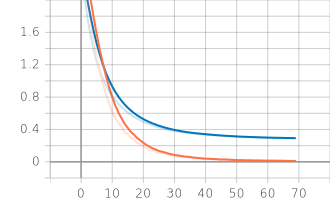

In [ ]:
from IPython.display import Image        
Image(filename='/content/epoch_loss.png')

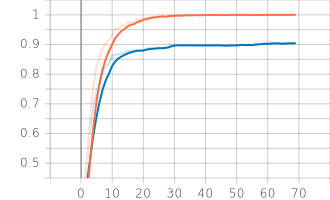

In [ ]:
from IPython.display import Image
Image(filename='/content/epoch_accuracy.png')

#Model Schematic

In [ ]:
from IPython.display import Image
Image(filename='/content/model_structure.png')

In [ ]:
train_loss, train_accuracy=model.evaluate_generator(train)
test_loss, test_accuracy=model.evaluate_generator(test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [ ]:
!pip install tensorboard

In [ ]:
print('Test Accuracy : {}%'.format(round(test_accuracy*100),2))    # Accuracy on the Test set
print('Test_Loss : {}'.format(test_loss)) #Final Test Loss
print('Train Accuracy : {}%'.format(round(train_accuracy*100),2) )   # Accuracy on the Train set
print('Train_Loss : {}' .format(train_loss) ) #Final Train loss

Test Accuracy : 90%
Test_Loss : 0.2913367748260498
Train Accuracy : 100%
Train_Loss : 0.0028922546189278364


In [ ]:
model.save('TL_Flowers_17_InceptionV3.h5')